# Image Classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [3]:
import numpy as np
from math import pi
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
'''
We don't really need this, but it might be nice to have if for future purposes. Currently it doesn't do anything for the notebook.
'''

# Convolutional vision network consisting of a convolutional layer followed by a fully connected layer and a final pass through a softmax function to yield predictive class
# probabilities 
class CVN(torch.nn.Module):
    def _init_(self, n_inputs, channels, n_outputs, patch_architecture, stride_architecture, convolutional_architecture, fully_connected_architecture, relu = False):
        # n_inputs corresponding to the number of pixels in the input image
        # channels corresponding to the number of channels in the input image, e.g. 1 for grayscale 
        # n_outputs corresponding to the number of classes the model intends to predict
        # patch_architecture that specifies the corresponding patch size, or one dimensional extent, of the kernel for each filter in convolutional_architecture
        # stride_architecture that specifies the corresponding stride parameter for each filter in convolutional_architecture
        # convolutional_architecture that specifies the number of features, or 'hidden layers', per each filter in the convolutional layer
        # fully_connected_architecture which specifies the number of outputs of each linear 'hidden layer' in the fully connected layer
        # relu to specify the activation function to use in each member of fully_connected_architecture. The alternative is tanh. Further implementation could offer other activation functions


        # Parent torch module class to inherit
        super().__init__() 

        # List of modules that will host containers of convolutional architecture
        self.cv_layers = torch.nn.ModuleList()
        in_channels = channels
        in_width = int(np.sqrt(n_inputs))
        # Actual conv layer construction
        for layer_architecture, patch_size, stride in zip(convolutional_architecture, patch_architecture, stride_architecture):
            self.cv.layers.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=layer_architecture, kernel_size=patch_size, stride=stride))
            # To keep track of 'image' width
            # Padding is not included
            output_width = (in_width - patch_size) // stride + 1
            in_channels = layer_architecture
            in_width = output_width
    
        self.activation_function = torch.relu if relu else torch.tanh

        # List of modules that will host containers of fully connected architecture
        self.fc_layers = torch.nn.ModuleList()

        # Construction of the fully connected layer
        # Make sure input dimension is adjusted for what's seen coming out of convolutional_architecture
        fc_input = in_width**2 * in_channels
        for layer_architecture in fully_connected_architecture:
            self.fc_layers.append(torch.nn.Sequential(torch.nn.Linear(fc_input, layer_architecture)))
        
        self.output_layer = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs), torch.nn.Softmax)

    # Forward pass via container to keep track of output at every layers. Returns the container
    def forward_pass_container(self, X):
        n_samples = X.shape[0]
        layer_outputs = [X] 
        # Pass through cv_layers
        for conv_layer in self.cv_layers:
            layer_outputs.append(self.activation_function(conv_layer(layer_outputs[-1])))
        # Pass through fully connected layers
        # First layer has to have dimension increased
        layer_outputs.append(self.activation_function(fc_layers[0](layer_outputs[-1].reshape(n_samples,-1))))
        # Rest of the layers except the final softmax
        for fc_layer in self.fc_layers[1:-1]:
            layer_outputs.append(self.activation_function(fc_layer(layer_outputs[-1])))
        #final softmax
        layer_outputs.append(torch.nn.Softmax(self.fc_layers[-1](layer_outputs[-1])))
        return layer_outputs

    # Forward pass to return total output
    def forward(self, X):
        return self.forward_pass_container(X)[-1]

    # Up to here there's a good sense of how this is supposed to work.  Training is the main problem because having unlabeled data means we have no way to correct.  The answer is
    # probably in k-means clustering.  This is feasible, but I think an easier first approach would just be the autoencoder approach where we extract features on the flattened image data and then
    # stride over the input to get a patch.  We could also just use random initialization until performance goes well.  The process of initializing the weights I am unfamiliar with though
    def unsupervised_train(self, X):
    # Training for updating all of the weights in the network
    def supervised_train(self, X, T, batch_size, epochs, learning_rate, sgd = True, verbose = True):
        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).long() # required for classification in pytorch
        X.requires_grad_(True)

        self.classes = torch.unique(T)
        
        if sgd:
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []
        
        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0
            
            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]
                
                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

### Convolutional Auto-encoder

In [99]:
import scipy
from scipy.ndimage import rotate
from scipy.ndimage import interpolation
import pandas as pd

In [6]:
# generate the data
def generate_samples(samples_curve, samples_shower, noise_sd, pixel_dimension):
    # sampeles_curve number of curve samples we want to include in our set
    # samples_shower number of shower samples we want to include in our set
    # noise_sd setting the scale of the background noise
    # pixel_dimension to set the image construction to pixel_dimension x pixel_dimension images
    background = np.random.normal(scale = noise_sd ,size = (samples_curve + samples_shower, pixel_dimension, pixel_dimension))
    curvlin_tracks = curvilinear_tracks(samples_curve, pixel_dimension) + background[:samples_curve]
    showers = shower_tracks(samples_shower, pixel_dimension) + background[samples_curve:]
    # returns fully reshaped images 
    return curvlin_tracks, showers

# makes the shower tracks randomly for generate samples
def shower_tracks(samples, pixel_dimension):
    # samples for the number of shower track images we want to generate
    vertices = np.random.uniform(0,pixel_dimension, size=(samples,2)).astype(int)
    thetas = np.random.uniform(0,360, samples)
    initials = np.random.uniform(0,pixel_dimension, size=(samples,2)).astype(int)
    shower_tracks = []
    for sample in range(samples):
        # generate the flattened conical shower at some point inside the frame
        base_cone = np.array([100*np.exp(-0.1*(x**2 + y**2)**0.5) if (((y-initials[sample][1]) < 2*(x-initials[sample][0])) and ((y-initials[sample][1]) > .5*(x-initials[sample][0])) and (np.random.uniform(0,1) < 0.5)) else 0 for x in range(pixel_dimension) for y in  range(pixel_dimension)])
        # reshape to the pixel map and then rotate the image
        shower_tracks.append(scipy.ndimage.interpolation.rotate(base_cone.reshape((pixel_dimension,pixel_dimension)), thetas[sample], reshape=False))
    # returns list of fully reshaped images
    return shower_tracks


# makes random linear track for generate samples
def curvilinear_tracks(n, pixel_dimension):
    # n number of curvilinear samples
    # pixel_dimension^2 number of pixels
    thetas = np.random.uniform(0,360, n)
    # make step count for each particle, i.e. decay time, scale appropriately to pixel dimension with numerical step size of 0.01
    steps = (np.random.uniform(0,200*pixel_dimension,n)).astype(int)
    # generate curvatures for an acceptable range given the dimensions. Normal distribution for curvature gives a more appropriate spread of track types
    curvatures =np.absolute(np.random.normal(0,0.04,n))
    curvlin_tracks = integrate_tracks(pixel_dimension, steps, curvatures)
    # returns list of fully reshaped images
    return curvlin_tracks

# builds curves based on the paramteric eq. for the constant curvature tracks
def integrate_tracks(pixel_dimension,steps, curvatures):
    # steps array of steps tells each image how long is should be integrated for
    # curvatures array of curvatures to randomly set the charge to mass ratio of each image sample we want to generate
    h = 0.01
    # create an array of rotations to apply to each image for variety
    thetas = np.random.uniform(0,360, len(steps))    
    curvlin_tracks = []
    # for particle in each bin, integrate according to its corresponding step count 
    for step, curvature, theta in zip(steps, curvatures, thetas): 
        # make sure the image starts at the top left corner to give the most room to rotate
        x_i =  -np.cos(0)/curvature + 1/curvature
        y_i = np.sin(0)/curvature  
        x = [x_i]
        y = [y_i]
        for i in range(step):
            x_next = -np.cos(h*i)/curvature + 1/curvature
            y_next = np.sin(h*i)/curvature 
            x.append(x_next)
            y.append(y_next)
        embedded_track = paste_track(pixel_dimension,x,y)
        # rotate image
        embedded_track = scipy.ndimage.interpolation.rotate(embedded_track, theta, reshape=False)
        curvlin_tracks.append(embedded_track)
        # returns list of fully reshaped images
    return curvlin_tracks

def paste_track(pixel_dimension, x,y):
    # x positions for the single track's points
    # y positions for the single track's points
    # make sure they are cast to ints in order to access pixel map
    x = np.array(x).astype(int)
    y = np.array(y).astype(int)
    grid = np.zeros((pixel_dimension, pixel_dimension))
    count = 0
    for x, y in zip(x, y):
        # only include the curve inside the map
        if (0 <= x < pixel_dimension) and (0 <= y < pixel_dimension):
            # account for the exponential decay
            grid[x][y] = 100 * np.exp(-0.001*count)
            count += 1
    return grid

In [7]:
curves, showers = generate_samples(10000, 50000, 0.1, 32)

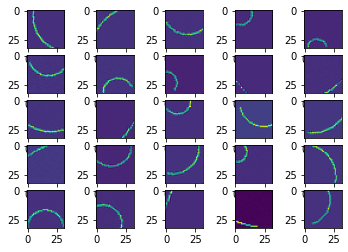

In [8]:
for i in range(25):
    plt.subplot(5,5,i + 1)
    plt.imshow(curves[i]);

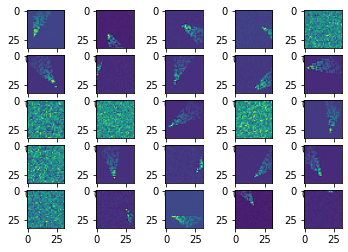

In [9]:
for i in range(25):
    plt.subplot(5,5,i + 1)
    plt.imshow(showers[i]);

In [10]:
# Convolutional Auto-encoder network consisting of a convolutional layer followed by a fully connected layer and a final pass through a softmax function to yield predictive class
# probabilities 
class CVAutoencoder(torch.nn.Module):
    def __init__(self, n_inputs, channels, patch_architecture, stride_architecture, convolutional_architecture, relu = False):
        # n_inputs corresponding to the number of pixels in the input image
        # channels corresponding to the number of channels in the input image, e.g. 1 for grayscale 
        # n_outputs corresponding to the number of classes the model intends to predict
        # patch_architecture that specifies the corresponding patch size, or one dimensional extent, of the kernel for each filter in convolutional_architecture
        # stride_architecture that specifies the corresponding stride parameter for each filter in convolutional_architecture
        # convolutional_architecture that specifies the number of features, or 'hidden layers', per each filter in the convolutional layer
        # fully_connected_architecture which specifies the number of outputs of each linear 'hidden layer' in the fully connected layer
        # relu to specify the activation function to use in each member of fully_connected_architecture. The alternative is tanh. Further implementation could offer other activation functions


        # Parent torch module class to inherit
        super().__init__() 

        # List of modules that will host containers of convolutional architecture
        self.cv_layers = torch.nn.ModuleList()
        in_channels = channels
        in_width = int(np.sqrt(n_inputs))
        # Actual conv layer construction
        for layer_architecture, patch_size, stride in zip(convolutional_architecture, patch_architecture, stride_architecture):
            self.cv_layers.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=layer_architecture, kernel_size=patch_size, stride=stride, padding=1))
            self.cv_layers.append(torch.nn.MaxPool2d(2,2))
            # To keep track of 'image' width
            # Padding is not included
            output_width = (in_width - patch_size) // stride + 1
            in_channels = layer_architecture
            in_width = output_width

        convolutional_architecture_reverse = convolutional_architecture[::-1]
        for i in range(len(convolutional_architecture)-1):
            self.cv_layers.append(torch.nn.ConvTranspose2d(in_channels=convolutional_architecture_reverse[i], out_channels=convolutional_architecture_reverse[i + 1], kernel_size=2, stride=2))
        self.cv_layers.append(torch.nn.ConvTranspose2d(in_channels=convolutional_architecture[0], out_channels=channels, kernel_size=2, stride=2))
        self.activation_function = torch.relu if relu else torch.tanh

        # List of modules that will host containers of fully connected architecture
        #self.fc_layers = torch.nn.ModuleList()

        # Construction of the fully connected layer
        # Make sure input dimension is adjusted for what's seen coming out of convolutional_architecture
        # fc_input = in_width**2 * in_channels
        # for layer_architecture in fully_connected_architecture:
        #     self.fc_layers.append(torch.nn.Sequential(torch.nn.Linear(fc_input, layer_architecture)))
        
        # self.output_layer = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs), torch.nn.Softmax)

    # Forward pass via container to keep track of output at every layers. Returns the container
    def forward_pass_container(self, X):
        n_samples = X.shape[0]
        layer_outputs = [X] 
        # Pass through cv_layers
        for conv_layer in self.cv_layers[:-1]:
            layer_outputs.append(self.activation_function(conv_layer(layer_outputs[-1])))
        # Pass through fully connected layers
        # First layer has to have dimension increased
        #layer_outputs.append(self.activation_function(fc_layers[0](layer_outputs[-1].reshape(n_samples,-1))))
        # Rest of the layers except the final softmax
        #for fc_layer in self.fc_layers[1:-1]:
        #    layer_outputs.append(self.activation_function(fc_layer(layer_outputs[-1])))
        #final softmax
        layer_outputs.append(torch.sigmoid(self.cv_layers[-1](layer_outputs[-1])))
        return layer_outputs

    # Forward pass to return total output
    def forward(self, X):
        return self.forward_pass_container(X)[-1]

    # Up to here there's a good sense of how this is supposed to work.  Training is the main problem because having unlabeled data means we have no way to correct.  The answer is
    # probably in k-means clustering.  This is feasible, but I think an easier first approach would just be the autoencoder approach where we extract features on the flattened image data and then
    # stride over the input to get a patch.  We could also just use random initialization until performance goes well.  The process of initializing the weights I am unfamiliar with though
    def unsupervised_train(self, X, batch_size, n_epochs, learning_rate, sgd = True, verbose = True):
        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        X.requires_grad_(True)
        
        if sgd:
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # Set loss function to binary cross entropy for auto-encoder error
        MSELoss = torch.nn.MSELoss() 
        self.error_trace = []
        
        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0
            
            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                
                Y = self.forward(X_batch)
                
                loss = MSELoss(Y, X_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'CVA: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

In [285]:
# automates the testing procedure for experiments and return a dictionary with the results
def test_harness(new_showers, curves, conv_architecture, lr, epochs, sgd = False, relu = False):
    # new_showers samples of cleaned up shower samples
    # curves samples of curvilinear tracks
    # conv_architecture layer of convolutions to parametrize the encoding scheme
    # lr rate of learning
    # sgd for stochastic gradient descent or adam as optimizers
    # relu for relu activation function within architecture else tanh
    background = np.random.normal(scale = 0.1 ,size = (len(curves), 32, 32))
    Xtest = np.concatenate((new_showers, curves, background), axis = 0).reshape(2*len(curves) + len(new_showers),1,32,32)
    X = np.concatenate((new_showers, curves), axis = 0).reshape(len(curves) + len(new_showers),1,32,32)
    # standardize for training
    X =  (X - np.mean(X,axis=0))/np.std(X,axis=0)
    patch_dimension = [3 for i in range(len(conv_architecture))]
    paddings = [1 for i in range(len(conv_architecture))]
    cva = CVAutoencoder(32*32, 1, patch_dimension, paddings, conv_architecture, relu=relu)
    cva.unsupervised_train(X,500,epochs,lr, sgd=sgd, verbose=False)
    # pull out values at the bottleneck
    fwd_containter = cva.forward_pass_container(torch.from_numpy(Xtest).float())
    bottleneck_representation = fwd_containter[2*len(conv_architecture)]
    features_confusion_df = representation_analysis(bottleneck_representation, 3, conv_architecture[-1], len(new_showers), len(curves))
    # returns dictionary of features whereby each feature key has associated with it a conf matrix and the kmeans centers and classification
    return features_confusion_df

# helps test_harness get the dictionary of dfs
def representation_analysis(X, k, num_features, new_shower_samples, curve_samples):
    # X data in new representation
    # k number of clusters
    # num_features number of features we're mapping to
    # new_shower_samples number of shower samples
    # curve_samples number of curvilinear samples
    centers_per_feature = []
    closests_per_feature = []
    feature_performance = []
    frames = {}
    features = np.arange(num_features).astype(str)
    for i in range(num_features):
        centers, closest = kmeans(X[:,i].flatten(1).detach().numpy(),k,50)
        centers_per_feature.append(centers)
        closests_per_feature.append(closest)
        # get the number of each cluster from the classification by nn
        feature_performance.append([np.unique(closest[:new_shower_samples], return_counts=True),np.unique(closest[new_shower_samples:new_shower_samples + curve_samples], return_counts=True), np.unique(closest[new_shower_samples + curve_samples:], return_counts=True)])
    for feature in features:
        conf_matrix = get_conf_matrix(feature_performance, new_shower_samples, curve_samples, feature.astype(int), k)
        frames[feature] = [conf_matrix,centers_per_feature[feature.astype(int)],closests_per_feature[feature.astype(int)]]
    # returns dictionary of features whereby each feature key has associated with it a conf matrix and the kmeans centers and classification
    return frames

# builds the confusion matrix for the ith feature
def get_conf_matrix(feature_performance, new_shower_samples, curve_samples, ith_feature, k):
    # list of features' performance along with classification numbers for each cluster
    # new_shower_samples number of shower samples
    # curve_samples number of curvilinear samples
    # ith_feature we are interested in
    # k clusters

    # turn performance metrics into percentage
    table = np.array(feature_performance)[:,:,1]*[1/new_shower_samples, 1/curve_samples, 1/curve_samples]
    # adjust table to account for noise being uniquely classified.  We must make sure we get a 3d vector
    for i, feature in enumerate(table):
        cluster_indices_per_set = np.array(feature_performance)[:,:,0][i]
        for j, cluster_indices in enumerate(cluster_indices_per_set):
            corrected =  np.zeros(k)
            corrected[cluster_indices] = feature[j]
            feature[j] = corrected
    conf_matrix = pd.DataFrame(list(table[ith_feature]), index=['shower', 'curve', 'noise'], columns=['cluster 1','cluster 2','cluster 3'])
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.4f}")
    # returns stylized conf_matrix as a df
    return conf_matrix

In [226]:
# prints out 9 images which correspond to selected representation of the subset of images in question and their cluster
def view_features(Xtest,feature_num, cluster_label, new_shower_samples, curve_samples, shower = True):
    # Xtest data
    # feature_num feature in question you want to look at
    # cluster_label which cluster you want to look at
    # new_shower_samples number of shower samples
    # curve_samples number of curve samples
    indices_noise =  np.arange(new_shower_samples)[closests_per_feature[feature_num][:new_shower_samples] == cluster_label] if shower else np.arange(curve_samples)[closests_per_feature[feature_num][new_shower_samples:new_shower_samples + curve_samples] == cluster_label]
    count = 0
    for i in indices_noise[0:9]:
        plt.subplot(3,3,count + 1)
        count += 1
        plt.imshow(Xtest[i][0]);

In [288]:
conf_dfs['0'][0].style.background_gradient(cmap='Blues').format("{:.4f}")
#view_features(Xtest,0,0,len(new_showers), len(curves), shower=False)

,cluster 1,cluster 2,cluster 3
shower,0.4849,0.5050,0.0101
curve,0.0267,0.0298,0.9435
noise,0.0000,0.0000,1.0000


In [11]:
X = np.concatenate((showers, curves), axis = 0).reshape(60000,1,32,32)
cva = CVAutoencoder(32*32, 1, [3,3], [1,1], [16,4])
cva.unsupervised_train(X,500,100,0.01, sgd=False)
fwd_containter = cva.forward_pass_container(torch.from_numpy(X).float())

CVA: Epoch 10 Loss 18.661
CVA: Epoch 20 Loss 18.654
CVA: Epoch 30 Loss 18.651


KeyboardInterrupt: 

In [13]:
fwd_containter = cva.forward_pass_container(torch.from_numpy(X).float())

Text(0, 0.5, 'mse')

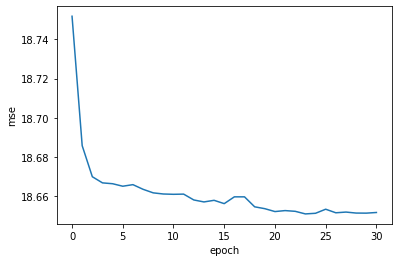

In [12]:
error_trace = [ element.detach().numpy() for element in cva.error_trace]
plt.plot(error_trace)
plt.xlabel('epoch')
plt.ylabel('mse')

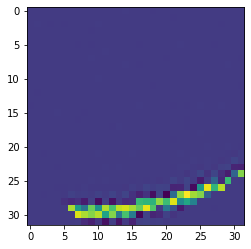

In [14]:
plt.imshow(X[-1][0]);

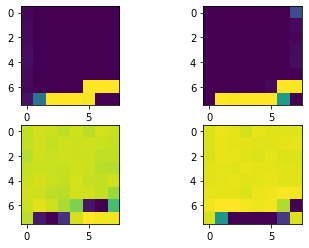

In [15]:
for feature in range(4):
    plt.subplot(2,2,feature + 1)
    plt.imshow(fwd_containter[4][-1][feature].detach().numpy())

We can now look into separating the features based on clustering in this lower dimensional space.  This means we will have as many classes as features plus one so that we include a negative result class.

In [16]:
def kmeans(data, k = 2, n_iterations = 5):
    
    # Initial centers
    centers = data[np.random.choice(range(data.shape[0]), k, replace=False), :]
    
    # Repeat n times
    for iteration in range(n_iterations):
        
        # Which center is each sample closest to?
        closest = np.argmin(np.sum((centers[:, np.newaxis, :] - data) ** 2, axis=2), axis=0)
        
        # Update cluster centers
        for i in range(k):
            centers[i, :] = data[closest == i, :].mean(axis=0)
            
    return centers, closest

In [17]:
num_feature = 4
centers_per_feature = []
closests_per_feature = []
feature_performance = []
for i in range(num_feature):
    centers, closest = kmeans(fwd_containter[4][:,i].flatten(1).detach().numpy(),2,50)
    centers_per_feature.append(centers)
    closests_per_feature.append(closest)
    feature_performance.append([np.unique(closest[:50000], return_counts=True),np.unique(closest[50000:], return_counts=True)])


In [18]:
feature_performance

[[(array([0, 1]), array([37881, 12119])),
  (array([0, 1]), array([7235, 2765]))],
 [(array([0, 1]), array([37621, 12379])),
  (array([0, 1]), array([6969, 3031]))],
 [(array([0, 1]), array([40444,  9556])),
  (array([0, 1]), array([9999,    1]))],
 [(array([0, 1]), array([ 9751, 40249])),
  (array([0, 1]), array([  10, 9990]))]]

In [19]:
indices_noise =  np.arange(50000)[closests_per_feature[0][:50000] == 1]

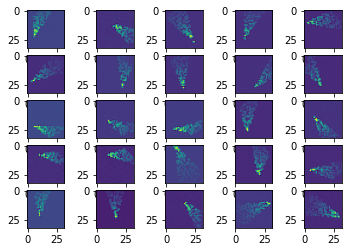

In [20]:
count = 0
for i in indices_noise[0:25]:
    plt.subplot(5,5,count + 1)
    count += 1
    plt.imshow(X[i][0]);

We can see that different features perform differently for our purpose if we want to determine .  We'll first want to run experiments on the number of features for the bottleneck.  Then we can run tests on architecture trying to push in the direction motivated by the paper.  Need to probably make an effort to get rid of noisey values.  This can actually follow iteratively from the process above.  

12119


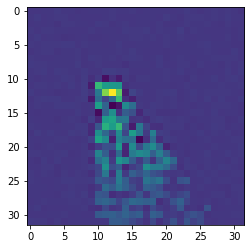

In [21]:
new_showers = showers[closests_per_feature[0][:50000] == 1]
print(len(new_showers))
plt.imshow(new_showers[-1]);

OK, cool fam

In [22]:
new_shower_samples = len(new_showers)

In [24]:
X = np.concatenate((new_showers, curves), axis = 0).reshape(10000 + new_shower_samples,1,32,32)
X_standardized =  (X - np.mean(X,axis=0))/np.std(X,axis=0)
X_standardized.shape

(22119, 1, 32, 32)

Showers seem to be high dimensional data points.  They are separable at the outset.  Tracks are separable at the filter level.  The major issue is that curvilinear tracks are being essentially classified as noise 

In [ ]:
indices_noise =  np.arange(new_shower_samples)[closests_per_feature[0][:new_shower_samples] == 1]

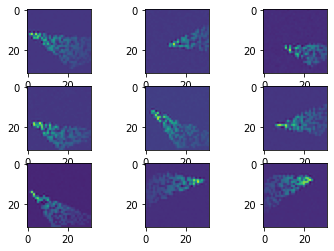

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i][0]);

In [ ]:
indices_noise =  np.arange(new_shower_samples)[closests_per_feature[0][:new_shower_samples] == 2]

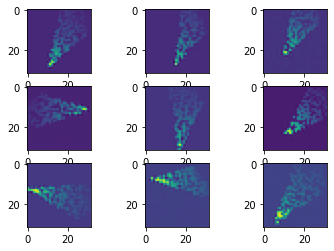

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i][0]);

In [ ]:
indices_noise =  np.arange(10000)[closests_per_feature[0][new_shower_samples:new_shower_samples + 10000] == 0]

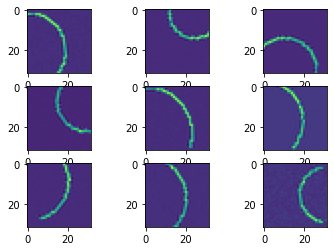

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i + new_shower_samples][0]);

In [ ]:
indices_noise =  np.arange(10000)[closests_per_feature[0][new_shower_samples:new_shower_samples + 10000] == 1]

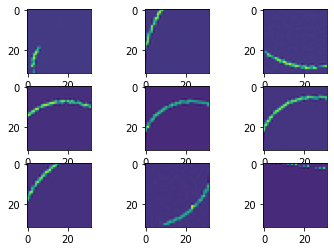

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i + new_shower_samples][0]);

In [ ]:
indices_noise =  np.arange(10000)[closests_per_feature[0][new_shower_samples:new_shower_samples + 10000] == 2]

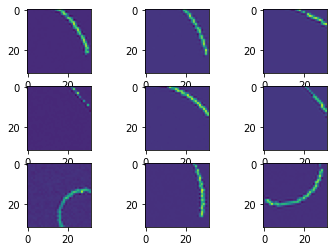

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i + new_shower_samples][0]);

In [ ]:
indices_noise =  np.arange(10000)[closests_per_feature[0][new_shower_samples:new_shower_samples + 10000] == 3]

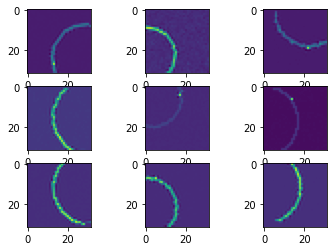

In [ ]:
count = 0
for i in indices_noise[0:9]:
    plt.subplot(3,3,count + 1)
    count += 1
    plt.imshow(Xtest[i + new_shower_samples][0]);

Still the same issue

Maybe we can aid this by including a clustering of the original data

In [ ]:
centers, closest = kmeans(np.concatenate((new_showers, curves, background), axis = 0).reshape(2*10000 + new_shower_samples, 1024),2,50)
np.unique(closest[:new_shower_samples], return_counts=True), np.unique(closest[new_shower_samples:new_shower_samples + 10000], return_counts=True), np.unique(closest[new_shower_samples + 10000:],return_counts=True)

((array([0]), array([9629])),
 (array([0, 1]), array([7154, 2846])),
 (array([0]), array([10000])))

In [262]:
conf_dfs = test_harness(new_showers, curves, [10,5,2], 0.01, 50, sgd = False, relu=True)

CVA: Epoch 5 Loss 0.994
CVA: Epoch 10 Loss 0.994
CVA: Epoch 15 Loss 0.994
CVA: Epoch 20 Loss 0.994
CVA: Epoch 25 Loss 0.994
CVA: Epoch 30 Loss 0.994
CVA: Epoch 35 Loss 0.994
CVA: Epoch 40 Loss 0.994
CVA: Epoch 45 Loss 0.994
CVA: Epoch 50 Loss 0.994
0
1


/var/folders/t8/_3p466f11l14337zj8hlgx1c0000gn/T/ipykernel_887/2872702058.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  table = np.array(feature_performance)[:,:,1]*[1/new_shower_samples, 1/curve_samples, 1/curve_samples]
/var/folders/t8/_3p466f11l14337zj8hlgx1c0000gn/T/ipykernel_887/2872702058.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noise_indices = [np.array(feature_performance)[:,:,0][i][2][arg_maxs[i]] for i in range(len(arg_maxs))]


In [292]:
import warnings
import time
warnings.filterwarnings("ignore")

In [293]:
architectures = [[4,2],[8,4],[16,8],[32,16]]
feature_scaling_results = {}
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 50, sgd = False, relu=True)
    print('architecture: ', architecture)    
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    feature_scaling_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")

architecture:  [4, 2]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.999917   0.000083     0.0000
curve    0.683900   0.149600     0.1665
noise    1.000000   0.000000     0.0000
feature : 1
        cluster 1  cluster 2  cluster 3
shower     0.0000      1.000     0.0000
curve      0.2493      0.502     0.2487
noise      0.0000      1.000     0.0000
Took  376.8559727668762  seconds
architecture:  [8, 4]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.000495   0.998267   0.001238
curve    0.298800   0.422100   0.279100
noise    0.000000   1.000000   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower     0.0000   0.999257   0.000743
curve      0.2432   0.560300   0.196500
noise      0.0000   1.000000   0.000000
feature : 2
        cluster 1  cluster 2  cluster 3
shower    0.00264    0.99736     0.0000
curve     0.23330    0.53440     0.2323
noise     0.00000    1.00000     0.0000
feature : 3
        cluster 1  cluster 2  cluster 3
shower   0.

In [295]:
architectures = [[5],[4,2],[10,6,3],[15,10,7,4]]
architecture_depth_results = {}
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 50, sgd = False, relu=True)
    print('architecture: ', architecture)    
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_depth_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")

architecture:  [5]
feature : 0
        cluster 1  cluster 2  cluster 3
shower     0.0000   0.000825   0.999175
curve      0.2706   0.297200   0.432200
noise      0.0000   0.000000   1.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower     0.0000   0.999917   0.000083
curve      0.2884   0.434400   0.277200
noise      0.0000   1.000000   0.000000
feature : 2
        cluster 1  cluster 2  cluster 3
shower      1.000     0.0000     0.0000
curve       0.641     0.1698     0.1892
noise       1.000     0.0000     0.0000
feature : 3
        cluster 1  cluster 2  cluster 3
shower   0.999917   0.000083      0.000
curve    0.386000   0.320000      0.294
noise    1.000000   0.000000      0.000
feature : 4
        cluster 1  cluster 2  cluster 3
shower     0.0000   0.999835   0.000165
curve      0.1679   0.635100   0.197000
noise      0.0000   1.000000   0.000000
Took  229.38591599464417  seconds
architecture:  [4, 2]
feature : 0
        cluster 1  cluster 2  cluster 3
shower      0

In [296]:
architectures = [[7,4,2],[10,7,3],[20,10,5],[35,20,10]]
architecture_3_scale_results = {}
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 50, sgd = False, relu=True)
    print('architecture: ', architecture)    
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_3_scale_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")

architecture:  [7, 4, 2]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.064609   0.058338   0.877053
curve    0.351600   0.341400   0.307000
noise    0.000000   0.000000   1.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower        0.0        1.0        0.0
curve         0.0        1.0        0.0
noise         0.0        1.0        0.0
Took  510.4923758506775  seconds
architecture:  [10, 7, 3]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.908491   0.042083   0.049427
curve    0.381400   0.308000   0.310600
noise    1.000000   0.000000   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower        0.0        1.0        0.0
curve         0.0        1.0        0.0
noise         0.0        1.0        0.0
feature : 2
        cluster 1  cluster 2  cluster 3
shower   0.048849   0.900322   0.050829
curve    0.313900   0.370200   0.315900
noise    0.000000   1.000000   0.000000
Took  663.5447537899017  seconds
architecture:  [20, 10,

In [297]:
architectures = [[35,20,10,4,2],[35,20,10,4,2]]
architecture_max_tanh_relu_results = {}
relu = True
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 50, sgd = False, relu=relu)
    print('architecture: ', architecture)    
    print('relu: ', relu)
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_max_tanh_relu_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")
    relu = False

architecture:  [35, 20, 10, 4, 2]
relu:  True
feature : 0
        cluster 1  cluster 2  cluster 3
shower    0.00198   0.484033   0.513986
curve     0.21910   0.196800   0.584100
noise     0.00000   1.000000   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.002145    0.49146   0.506395
curve    0.216000    0.20020   0.583800
noise    0.000000    1.00000   0.000000
Took  1361.6873478889465  seconds
architecture:  [35, 20, 10, 4, 2]
relu:  False
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.535605   0.415216   0.049179
curve    0.385900   0.505000   0.109100
noise    0.000300   0.999700   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.056688    0.47801   0.465302
curve    0.129900    0.35330   0.516800
noise    0.000000    0.00000   1.000000
Took  1301.164647102356  seconds


In [298]:
architectures = [[35,20,10,4,2],[35,20,10,4,2]]
architecture_max_sgd_adam_results = {}
sgd = True
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 50, sgd = sgd, relu=False)
    print('architecture: ', architecture)    
    print('sgd: ', sgd)
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_max_sgd_adam_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")
    sgd = False

architecture:  [35, 20, 10, 4, 2]
sgd:  True
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.376351    0.24474   0.378909
curve    0.572900    0.09440   0.332700
noise    0.997000    0.00000   0.003000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.307204   0.448469   0.244327
curve    0.168500   0.397500   0.434000
noise    0.000000   0.000300   0.999700
Took  1323.4167580604553  seconds
architecture:  [35, 20, 10, 4, 2]
sgd:  False
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.405231   0.158264   0.436505
curve    0.280800   0.061200   0.658000
noise    0.000000   0.000000   1.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower        0.0        1.0        0.0
curve         0.0        1.0        0.0
noise         0.0        1.0        0.0
Took  1220.8511848449707  seconds


In [299]:
architectures = [[35,20,10,4,2],[35,20,10,4,2],[35,20,10,4,2]]
architecture_epochs_results = {}
epochs = 25
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, epochs, sgd = True, relu=False)
    print('architecture: ', architecture)    
    print('epochs: ', epochs)
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_epochs_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")
    epochs+=25

architecture:  [35, 20, 10, 4, 2]
epochs:  25
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.528096   0.311164   0.160739
curve    0.420600   0.227300   0.352100
noise    0.999300   0.000700   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.191848   0.403581   0.404571
curve    0.231800   0.459800   0.308400
noise    0.000000   0.000300   0.999700
Took  658.3478231430054  seconds
architecture:  [35, 20, 10, 4, 2]
epochs:  50
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.285667   0.432544   0.281789
curve    0.477800   0.315100   0.207100
noise    1.000000   0.000000   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.192425   0.404489   0.403086
curve    0.177900   0.398600   0.423500
noise    0.000100   0.999900   0.000000
Took  1279.30841588974  seconds
architecture:  [35, 20, 10, 4, 2]
epochs:  75
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.542124   0.372638   0.085238
curve    0.189700

In [300]:
architectures = [[35,20,10,4,2],[80,50,30,15,5]]
architecture_deepest_results = {}
for architecture in architectures:
    start = time.time()
    conf_dict = test_harness(new_showers, curves, architecture, 0.01, 100, sgd = True, relu=False)
    print('architecture: ', architecture)  
    for feature in np.arange(architecture[-1]).astype(str):
        print('feature :',feature)
        print(conf_dict[feature][0])
    architecture_deepest_results[str(architecture)] = conf_dict
    print("Took ", time.time() - start, " seconds")

architecture:  [35, 20, 10, 4, 2]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.369585   0.490552   0.139863
curve    0.321100   0.347100   0.331800
noise    0.000000   0.000100   0.999900
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.271475   0.459361   0.269164
curve    0.348000   0.486100   0.165900
noise    0.000000   1.000000   0.000000
Took  2550.192382335663  seconds
architecture:  [80, 50, 30, 15, 5]
feature : 0
        cluster 1  cluster 2  cluster 3
shower   0.353247   0.198036   0.448717
curve    0.369900   0.184300   0.445800
noise    1.000000   0.000000   0.000000
feature : 1
        cluster 1  cluster 2  cluster 3
shower   0.364964   0.204802   0.430234
curve    0.495700   0.164300   0.340000
noise    0.997900   0.000000   0.002100
feature : 2
        cluster 1  cluster 2  cluster 3
shower   0.040927   0.461012   0.498061
curve    0.379000   0.518700   0.102300
noise    1.000000   0.000000   0.000000
feature : 3
        cluster 1  cluster

In [380]:
architecture_depth_results['[15, 10, 7, 4]']['2'][0].style.background_gradient(cmap='Blues').format("{:.4f}")

,cluster 1,cluster 2,cluster 3
shower,0.5118,0.4853,0.0030
curve,0.5778,0.2059,0.2163
noise,0.0000,1.0000,0.0000
